In [2]:
"""
ENGD Optimization.
Two dimensional Poisson equation example. Solution given by

u(x,y) = sin(pi*x) * sin(py*y).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit

from ngrad.models import init_params, mlp
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.utility import laplace, grid_line_search_factory
from ngrad.inner import model_laplace, model_identity
from ngrad.gram import gram_factory, nat_grad_factory

jax.config.update("jax_enable_x64", True)

tau = 1.

# random seed
seed = 0

# domains
interior = Square(1.)
boundary = SquareBoundary(1.)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
boundary_integrator = DeterministicIntegrator(boundary, 30)
eval_integrator = DeterministicIntegrator(interior, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
# v_model = vmap(model, (None, 0))
v_model = vmap(lambda params, x: model(params, x), (None, 0))

# solution
@jit
def u_star(x):
    return jnp.prod(jnp.sin(jnp.pi * x))

# rhs
@jit
def f(x):
    return 2. * jnp.pi**2 * u_star(x)

# gramians
gram_bdry = gram_factory(
    model = model,
    trafo = model_identity,
    integrator = boundary_integrator
)

gram_laplace = gram_factory(
    model = model,
    trafo = model_laplace,
    integrator = interior_integrator
)

@jit
def gram(params):
    return gram_laplace(params) + gram_bdry(params)

# natural gradient
nat_grad = nat_grad_factory(gram)

# compute residual
laplace_model = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    return tau * boundary_integrator(lambda x: v_model(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# set up grid line search
grid = jnp.linspace(0, 30, 31)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    


iterations = 20000
save_freq = 10

import numpy as np
data = np.empty((iterations // save_freq + 1, 5))

# natural gradient descent with line search
for iteration in range(iterations + 1):
    grads = grad(loss)(params)
    nat_grads = nat_grad(params, grads)
    params, actual_step = ls_update(params, nat_grads)
    
    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
        
        data[iteration // save_freq, :] = [
            iteration,
            interior_loss(params),
            boundary_loss(params),
            l2_error,
            h1_error,
        ]
    
        print(
            f'ENGD Iteration: {iteration}'
            f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
            f'\n  with step: {actual_step}'
        )
        
# jnp.save("data/engd.npy", data)


ENGD Iteration: 0
  with loss: 57126.37499715346 + 183.78137210375544 = 57310.156369257216
  with error L2: 6.94736839583799 and error H1: 30.125569499945385
  with step: 1e-05
ENGD Iteration: 10
  with loss: 57103.54890652908 + 183.70645066452002 = 57287.2553571936
  with error L2: 6.9459505691256895 and error H1: 30.119508805400613
  with step: 1e-05
ENGD Iteration: 20
  with loss: 57080.72912716221 + 183.6324181401414 = 57264.36154530235
  with error L2: 6.944551568393402 and error H1: 30.113478249192084
  with step: 1e-05
ENGD Iteration: 30
  with loss: 57057.91025170661 + 183.55931825336225 = 57241.469569959976
  with error L2: 6.943170597127951 and error H1: 30.107477284739105
  with step: 1e-05
ENGD Iteration: 40
  with loss: 57035.092585083825 + 183.4863985191064 = 57218.57898360293
  with error L2: 6.941795053537593 and error H1: 30.101475244555
  with step: 1e-05
ENGD Iteration: 50
  with loss: 57012.28277478223 + 183.4133111923774 = 57195.69608597461
  with error L2: 6.94041

KeyboardInterrupt: 

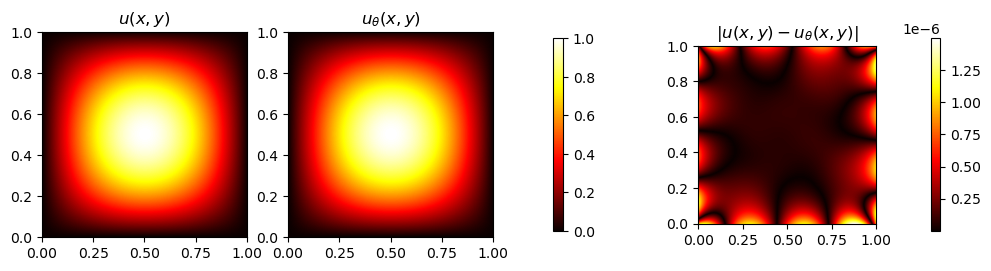

In [2]:
from util import save


n = 300
save("engd", n, u_star, v_model, params)